# Project : Walmart TripType Classification


# 1. Data Introduce
### 1.1 Purpose : Use market basket analysis to classify shopping trips
    

### 1.2 Data set:
   > - Train Data : 647054 rows, 7 columns

   > - Test Data  : 653646 rows, 6 columns
   
   > - Submission Data  : 95674 rows, 39 columns
      
   > - [Source Link : Walmart TripType : Recruiting-trip-type-classification](https://www.kaggle.com/c/walmart-recruiting-trip-type-classification)

### 1.3 Evaluation
   > - multi-class logarithmic loss
   > $$-\frac{1}{N}\sum_{i=1}^N\sum_{j=1}^My_{ij}\log(p_{ij})$$

# Data Format

In [1]:
import numpy as np
import pandas as pd
from IPython.display import Markdown

# Import the functions used in this project
import modeling_danial.awesome_functions as af
import modeling_danial.decode_utils as du
from modeling_danial.feature_engineering import *  
import matplotlib.pyplot as plt

# Pretty display for notebooks
%matplotlib inline

# Ignore the warnings
import warnings
warnings.filterwarnings('ignore')

import lightgbm
from scipy.sparse import csr_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

df_train = pd.read_csv("./asset/train.csv")
df_test = pd.read_csv("./asset/test.csv")
df_submission = pd.read_csv("./asset/sample_submission.csv")

In [2]:
train = df_train.copy()
test = df_test.copy()

In [3]:
display(Markdown('## Train DataFrame'))
display(df_train.tail())
display(df_train.shape)
display(Markdown('## Test DataFrame'))
display(df_test.tail())
display(df_test.shape)

## Train DataFrame

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
647049,39,191346,Sunday,3.239000e+10,1,PHARMACY OTC,1118.0
647050,39,191346,Sunday,7.874205e+09,1,FROZEN FOODS,1752.0
647051,39,191346,Sunday,4.072000e+03,1,PRODUCE,4170.0
647052,8,191347,Sunday,4.190008e+09,1,DAIRY,1512.0
647053,8,191347,Sunday,3.800060e+09,1,GROCERY DRY GOODS,3600.0


(647054, 7)

## Test DataFrame

,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
653641,191348,Sunday,6.657211e+10,1,BATH AND SHOWER,1505.0
653642,191348,Sunday,8.818139e+10,1,BATH AND SHOWER,1099.0
653643,191348,Sunday,4.282557e+09,1,MENS WEAR,8220.0
653644,191348,Sunday,8.046919e+10,1,SWIMWEAR/OUTERWEAR,114.0
653645,191348,Sunday,7.871536e+09,1,MENS WEAR,4923.0


(653646, 6)

## Brief Column Description
   > - TripType :  구매자의 구매 활동을 대표하는 카테고리성 아이디, 라벨값을 의미한다.
   
   > - VisitNumber : 단일 구매자의 단일 구매 활동을 대표하는 아이디이다.
   
   > - Weekday :  구매활동을 한 요일을 의미한다.
   
   > - Upc : Universal Product Code 를 의미한다. 
   
   > - ScanCount : 해당 아이템을 몇 개를 샀는지에 대한 정보가 담겨져있다. 음수값은 반환을 의미한다.
   
   > - DepartmentDescription : 아이템 분류의 가장 높은 범주를 의미한다.
   
   > - FinelineNumber : 월마트에서 자체적으로 제공하는 더 세분화된 상품 분류 코드이다.

In [4]:
display(df_submission.tail())
display(df_submission.shape)

,VisitNumber,TripType_3,TripType_4,TripType_5,TripType_6,TripType_7,TripType_8,TripType_9,TripType_12,TripType_14,...,TripType_36,TripType_37,TripType_38,TripType_39,TripType_40,TripType_41,TripType_42,TripType_43,TripType_44,TripType_999
95669,191338,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95670,191339,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95671,191340,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95672,191341,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95673,191348,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(95674, 39)

# 2. EDA

## Distribution of goods by TripType

In [5]:
train.tail()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
647049,39,191346,Sunday,3.239000e+10,1,PHARMACY OTC,1118.0
647050,39,191346,Sunday,7.874205e+09,1,FROZEN FOODS,1752.0
647051,39,191346,Sunday,4.072000e+03,1,PRODUCE,4170.0
647052,8,191347,Sunday,4.190008e+09,1,DAIRY,1512.0
647053,8,191347,Sunday,3.800060e+09,1,GROCERY DRY GOODS,3600.0


In [6]:
train_40 = train[train['TripType']==40]
train_40_groupby = train_40.groupby('DepartmentDescription',as_index=False)['ScanCount'].count()
train_40_groupby = train_40_groupby.sort_values('ScanCount',ascending=False)
train_39 = train[train['TripType']==39]
train_39_groupby = train_39.groupby('DepartmentDescription',as_index=False)['ScanCount'].count()
train_39_groupby = train_39_groupby.sort_values('ScanCount',ascending=False)

Text(0.5,1,'Distribution of DD at TripType = 40')

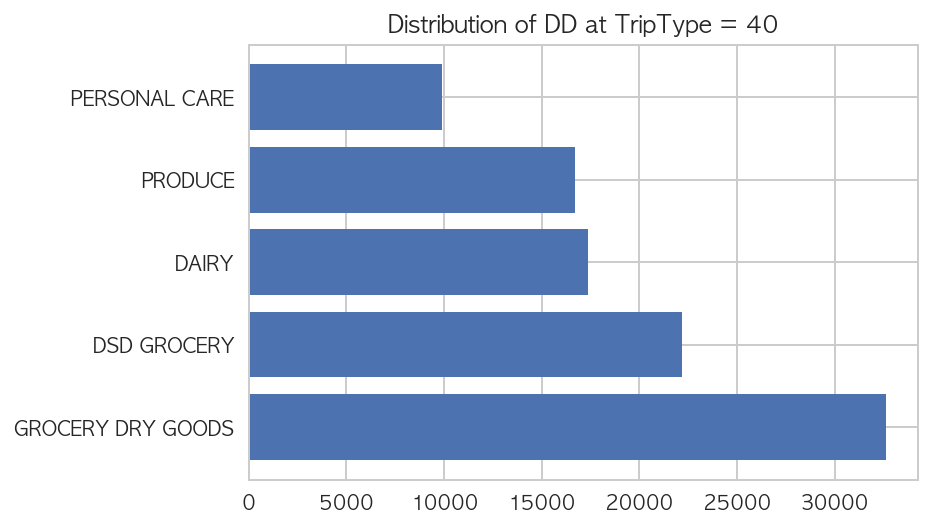

In [7]:
plt.barh((train_40_groupby['DepartmentDescription'][:5]) , (train_40_groupby['ScanCount'][:5]))
plt.title('Distribution of DD at TripType = 40')

Text(0.5,1,'Distribution of DD at TripType = 39')

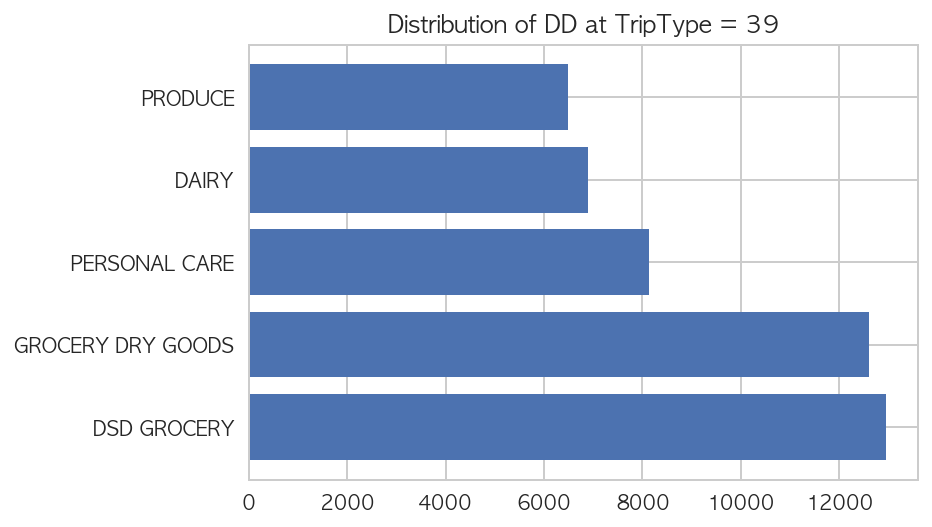

In [8]:
plt.barh((train_39_groupby['DepartmentDescription'][:5]) , (train_39_groupby['ScanCount'][:5]))
plt.title('Distribution of DD at TripType = 39')

#### 각각의 TripType은 각기 다른 DepartmentDescription 분포(특성) 를 띈다.

## TripType '999' indicating other items

In [9]:
train_tt_sc = train.groupby('TripType',as_index=False)['ScanCount'].sum()

(-5000, 50000)

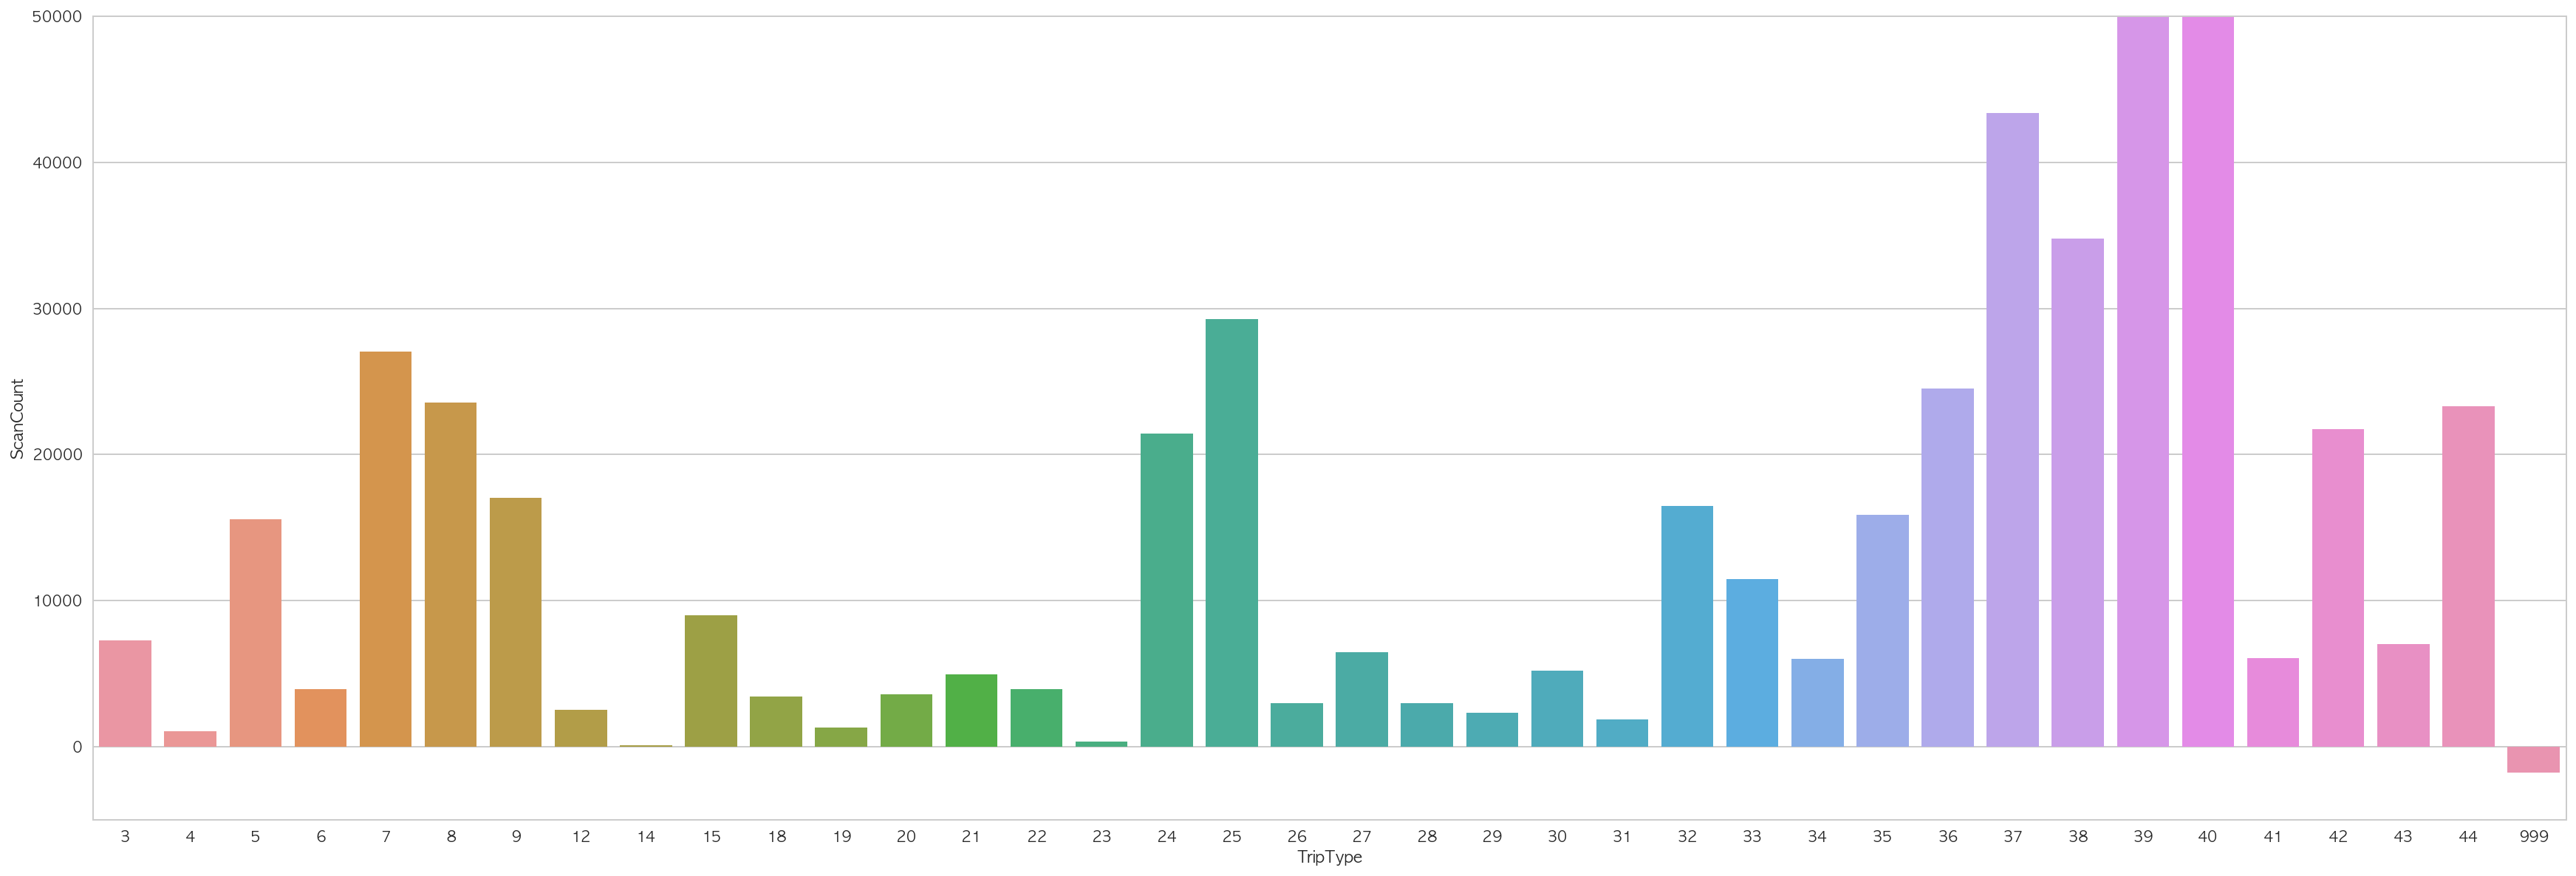

In [10]:
import seaborn as sns
plt.figure(figsize=(30,10))
sns.barplot(train_tt_sc['TripType'].astype('int') , train_tt_sc['ScanCount'])
plt.ylim(-5000,50000)

### TripType '999' 는 총 구매한 아이템의 수가 음수, 즉 최종 구매 활동이 `반환` 인 구매자를 의미한다.

## Deal with Missing value

In [11]:
train.isna().sum()

TripType                    0
VisitNumber                 0
Weekday                     0
Upc                      4129
ScanCount                   0
DepartmentDescription    1361
FinelineNumber           4129
dtype: int64

In [12]:
null_index = sorted(list(set(train[train['Upc'].isna()].index).intersection(set(train[train['FinelineNumber'].isna()].index))))
null_train_df = train.loc[null_index,:]#.reset_index(drop=True)

In [13]:
null_train_df['DepartmentDescription'].value_counts().reset_index()

,index,DepartmentDescription
0,PHARMACY RX,2768


In [14]:
null_train_df.iloc[:10,:]

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
25,26,8,Friday,NaN,1,NaN,NaN
548,27,259,Friday,NaN,3,NaN,NaN
549,27,259,Friday,NaN,1,NaN,NaN
959,999,409,Friday,NaN,-1,NaN,NaN
1116,39,479,Friday,NaN,1,NaN,NaN
1134,999,484,Friday,NaN,-2,NaN,NaN
1135,999,484,Friday,NaN,-2,NaN,NaN
1155,44,496,Friday,NaN,1,PHARMACY RX,NaN
1216,5,521,Friday,NaN,1,PHARMACY RX,NaN
1373,5,585,Friday,NaN,1,PHARMACY RX,NaN


> - FinelineNumber와 Upc 컬럼이 결측치인 경우, DepartmentDescription 컬럼은 함께 결측치를 띄거나 `PHARMACY RX`이다.

### Imputation on FinelineNumber , Upc

In [15]:
null_train_df

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
25,26,8,Friday,NaN,1,NaN,NaN
548,27,259,Friday,NaN,3,NaN,NaN
549,27,259,Friday,NaN,1,NaN,NaN
959,999,409,Friday,NaN,-1,NaN,NaN
1116,39,479,Friday,NaN,1,NaN,NaN
1134,999,484,Friday,NaN,-2,NaN,NaN
1135,999,484,Friday,NaN,-2,NaN,NaN
1155,44,496,Friday,NaN,1,PHARMACY RX,NaN
1216,5,521,Friday,NaN,1,PHARMACY RX,NaN
1373,5,585,Friday,NaN,1,PHARMACY RX,NaN


In [16]:
ls1 = train[train['DepartmentDescription']=='PHARMACY RX'].index
ls2 = null_train_df[null_train_df['DepartmentDescription']=='PHARMACY RX'].index
ls3 = list(set(ls1).difference(set(ls2)))
most_freq_pharmacy_rx = train.loc[ls3,:]
most_feq_upc = most_freq_pharmacy_rx['Upc']
most_feq_fl = most_freq_pharmacy_rx['FinelineNumber']
most_feq_upc = most_feq_upc.value_counts().index[0]
most_feq_fl = most_feq_fl.value_counts().index[0]

In [17]:
most_feq_upc , most_feq_fl

(30169183702.0, 4822.0)

### DepartmentDescription 컬럼이  `PHARMACY RX` 이고, 나머지 아이템 컬럼이 결측치일 때, 위의 두 가지 코드로 채워준다.

### 세 가지 아이템 컬럼이 모두 결측치를 띄는 경우에는, 아래의 값으로 Imputation 한다.
> - DepartmentDescription: NULL 

> - FinelineNumber: 1.1 

> - Upc: -9999 respectively.

## Our initial hypothesis after EDA
> ### (1) The most important factor determining TripType is `which item the buyer bought.`
> ### (1) TripType 이 정해지는 데에 가장 중요한 요소는 `어떠한 아이템을 샀는가`이다.
> ### (2) 구매자들 즉, VisitNumber 마다 각기 구분되는 `구매 패턴`을 띄고 있다.
> ### (3)  즉, 고유한 VisitNumber가 가지고 있는 잘 나오는 `주사위 면`을 가지고 있고, 이에 따라 라벨이 정해진다.

# 3. Feature Engineering
- 1) UPC decoding
- 2) Feature what we used

## UPC Decoding
- https://www.kaggle.com/c/walmart-recruiting-trip-type-classification/discussion/18158

- 만약 Upc가 결측치라면 -9999를 채워준다.
- There are some products in the dataset with a length of 4 or 5. It seemed that these are the in-house products (PRODUCE)
- 코드의 길이가 5 이하라면. 월마트 내부에서 자체적으로 생산하는 물품인 경우로 보여진다.(HOUSE)

In [18]:
print('Before Decoding: ',len(train['Upc'].unique()))
print('After Decoding: ',len(du.decodeStuffNeedsToBeDecoded(train)['Company'].unique()))

Before Decoding:  97715
After Decoding:  5687


## Feature What we MADE and USED
> - DepartmentDescription_dummies -- 68 length columns

> - FinelineNumber_dummies -- 5355 length columns

> - Company_dummies -- 5687 length columns

> - Item_dummies -- 10007 length columns

> - Weekday_dummies -- 7 length columns

> - Others -- 3 length columns
    - N_DD ()
    - N_FL ()
    - N_Company () 


### UPC, FinelineNumber, DepartmentDescription 결측치 처리 및 Decoding을 통해서 COMPANY, ITEM_NBR을 추가함.

In [19]:
df_decoded = du.decodeStuffNeedsToBeDecoded(df_train)

In [20]:
df_test_decoded = du.decodeStuffNeedsToBeDecoded(df_test)

### VisitNumber 별로 TripType은 하나만 부여되므로 VisitNumber를 기준으로 Group을 이루고, 카테고리 당 구매한 개수를 Value로 하여 Pivot table을 만든다.

In [21]:
%time df_train_fl = get_pivor_df(df_decoded, "FinelineNumber")
df_train_fl = df_train_fl.reset_index()
%time df_test_fl = get_pivor_df(df_test_decoded, "FinelineNumber")
df_test_fl = df_test_fl.reset_index()

CPU times: user 51.3 s, sys: 19.9 s, total: 1min 11s
Wall time: 1min 12s
CPU times: user 52.4 s, sys: 18.8 s, total: 1min 11s
Wall time: 1min 12s


In [22]:
%time df_train_dd = get_pivor_df(df_decoded, "DepartmentDescription")
df_train_dd = df_train_dd.reset_index()
%time df_test_dd = get_pivor_df(df_test_decoded, "DepartmentDescription")
df_test_dd = df_test_dd.reset_index()

CPU times: user 652 ms, sys: 204 ms, total: 855 ms
Wall time: 859 ms
CPU times: user 638 ms, sys: 188 ms, total: 826 ms
Wall time: 831 ms


### Train과 Test의 fineline_number는 완전 일치하지는 않는다. 

In [23]:
len(df_train_fl.columns), len(df_test_fl.columns)

(5197, 5205)

### 교집합 5047개만 남기도록 한다.

In [24]:
fl_cols = np.intersect1d(df_train_fl.columns, df_test_fl.columns)
len(np.intersect1d(df_train_fl.columns, df_test_fl.columns))

5047

In [25]:
df_train_fl = df_train_fl[fl_cols]
df_test_fl = df_test_fl[fl_cols]
df_train_fl.shape, df_test_fl.shape

((95674, 5047), (95674, 5047))

### Visitnumber 당 구매한 카테고리 갯수를 컬럼별로 저장

In [26]:
num_dd = get_num_of_categories_per_users(df_decoded)
num_fl = get_num_of_categories_per_users(df_decoded, "FinelineNumber")
len(num_dd), len(num_fl)

(95674, 95674)

In [27]:
num_dd_test = get_num_of_categories_per_users(df_test_decoded)
num_fl_test = get_num_of_categories_per_users(df_test_decoded, "FinelineNumber")
len(num_dd_test), len(num_fl_test)

(95674, 95674)

### DepartmentDescription의 MENSWEAR, MENS WEAR 컬럼은 의미가 같으므로 합쳐준다.

In [28]:
df_train_dd["MENSWEAR"] = df_train_dd["MENS WEAR"] + df_train_dd["MENSWEAR"]
df_train_dd.drop("MENS WEAR", axis = 1, inplace=True)
df_test_dd["MENSWEAR"] = df_test_dd["MENS WEAR"] + df_test_dd["MENSWEAR"]
df_test_dd.drop("MENS WEAR", axis = 1, inplace=True)
len(df_train_dd.columns), len(df_test_dd.columns)

(69, 68)

### HEALTH AND BEAUTY AIDS도 Test에는 없으므로 Drop 한다.

In [29]:
for col in df_train_dd.columns:
    if col not in df_test_dd.columns:
        print(col)

HEALTH AND BEAUTY AIDS


In [30]:
df_train_dd.drop("HEALTH AND BEAUTY AIDS", axis = 1, inplace=True)
len(df_train_dd.columns), len(df_test_dd.columns)

(68, 68)

In [31]:
df_train_fl.drop("VisitNumber", axis = 1, inplace=True)
df_test_fl.drop("VisitNumber", axis = 1, inplace=True)

In [32]:
%time df_train_dd = pd.DataFrame(np.where(df_train_dd < 0, 0, df_train_dd), columns=df_train_dd.columns)
%time df_test_dd = pd.DataFrame(np.where(df_test_dd < 0, 0, df_test_dd), columns=df_test_dd.columns)

CPU times: user 36 ms, sys: 27.6 ms, total: 63.6 ms
Wall time: 61.6 ms
CPU times: user 29.4 ms, sys: 32.1 ms, total: 61.5 ms
Wall time: 61.1 ms


In [33]:
df_feature = pd.concat([df_train_dd, df_train_fl], axis = 1)
df_feature_test = pd.concat([df_test_dd, df_test_fl], axis = 1)
len(df_feature), len(df_feature_test)

(95674, 95674)

### 각 VisitNumber 당 Scan한 총합을 추가.

In [34]:
def get_scancount_li(df_decoded):
    tmp = df_decoded.groupby(["VisitNumber", "DepartmentDescription"]).agg({"ScanCount" : np.sum}).reset_index()
    tmp = tmp.groupby("VisitNumber").sum()["ScanCount"].reset_index(name='ScanCount')
    sc_li = tmp.ScanCount.values # 95674
    return sc_li

In [35]:
sc_li = get_scancount_li(df_decoded)
sc_li_test = get_scancount_li(df_test_decoded)

In [36]:
df_feature["Scancount_total"] = sc_li
df_feature_test["Scancount_total"] = sc_li_test

### 다른 정보들을 만든다.

In [37]:
df_feature["N_DD"] = num_dd
df_feature["N_FL"] = num_fl
df_feature_test["N_DD"] = num_dd_test
df_feature_test["N_FL"] = num_fl_test

In [38]:
row_count = df_decoded.groupby("VisitNumber").count()["TripType"].values
df_feature["ROW_CNT"] = row_count
row_count_test = df_test_decoded.groupby("VisitNumber").count()["DepartmentDescription"].values
df_feature_test["ROW_CNT"] = row_count_test

In [39]:
df_feature["FL_DIV_DD"] = df_feature["N_FL"].div(df_feature["N_DD"], axis = 0)
df_feature_test["FL_DIV_DD"] = df_feature_test["N_FL"].div(df_feature_test["N_DD"], axis = 0)

In [40]:
df_feature["TripType"] = df_train.groupby(["VisitNumber", "TripType"]).size().reset_index()["TripType"]

### Weekdays Dummy로 만든다.

In [41]:
def make_df_we_wanted(df):
    result = df.copy()
    result["Weekday"] = __change_weekday_to_number(result)
    return __make_weekday_as_dummies(result)

def __change_weekday_to_number(df):
    weekday_dict = {
        "Monday" : 1,
        "Tuesday" : 2,
        "Wednesday" : 3,
        "Thursday" : 4,
        "Friday" : 5,
        "Saturday" : 6,
        "Sunday" : 7
    }
    return df["Weekday"].map(weekday_dict)

def __make_weekday_as_dummies(df):
    # finelinenumber를 column으로 만든경우에는 1,2,3,4,5,6,7 중에 몇개가 중복될 위험이 있어서 다시 명시적으로 바꿔준다.
    weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    dummies_desc = pd.get_dummies(df["Weekday"])
    dummies_desc.columns = weekdays
    desc_cols = dummies_desc.columns
    df[desc_cols] = dummies_desc
    li = [np.max for i in weekdays]
    dict_ = dict(zip(weekdays, li))
    result = df.drop("Weekday", axis = 1).groupby("VisitNumber").agg(dict_).reset_index()
    return result.drop("VisitNumber", axis = 1)

In [42]:
weekday_dummies = make_df_we_wanted(df_decoded)

In [43]:
weekday_dummies_test = make_df_we_wanted(df_test_decoded)

In [44]:
df_feature = pd.concat([df_feature, weekday_dummies], axis = 1)
df_feature_test = pd.concat([df_feature_test, weekday_dummies_test], axis = 1)
df_feature.shape, df_feature_test.shape

((95674, 5127), (95674, 5126))

### Return 정보 추가

In [45]:
df_feature["Return"] = df_feature.Scancount_total.apply(lambda a : 1 if a < 0 else 0)
df_feature_test["Return"] = df_feature_test.Scancount_total.apply(lambda a : 1 if a < 0 else 0)

In [46]:
fl_cols = [col for col in df_train_fl.columns]
dd_cols = [col for col in df_train_dd.columns if col != "VisitNumber"]
len(fl_cols), len(dd_cols)

(5046, 67)

In [47]:
%time df_feature = pd.DataFrame(np.where(df_feature == np.inf, 0, df_feature), columns=df_feature.columns)
%time df_feature = pd.DataFrame(np.where(df_feature == -np.inf, 0, df_feature), columns=df_feature.columns)
%time df_feature_test = pd.DataFrame(np.where(df_feature_test == np.inf, 0, df_feature_test), columns=df_feature_test.columns)
%time df_feature_test = pd.DataFrame(np.where(df_feature_test == -np.inf, 0, df_feature_test), columns=df_feature_test.columns)

CPU times: user 9.96 s, sys: 12 s, total: 21.9 s
Wall time: 23.2 s
CPU times: user 2.4 s, sys: 1.99 s, total: 4.39 s
Wall time: 4.39 s
CPU times: user 10.1 s, sys: 12.5 s, total: 22.6 s
Wall time: 23.6 s
CPU times: user 2.41 s, sys: 1.88 s, total: 4.29 s
Wall time: 4.29 s


In [48]:
tmp_num_dd = np.where(df_feature.N_DD == 0, 1, df_feature.N_DD)
%time df_feature[dd_cols] = df_feature[dd_cols].div(tmp_num_dd, axis = 0)
%time df_feature[fl_cols] = df_feature[fl_cols].div(tmp_num_dd, axis = 0)

CPU times: user 72.1 ms, sys: 56.9 ms, total: 129 ms
Wall time: 136 ms
CPU times: user 7.08 s, sys: 7.27 s, total: 14.3 s
Wall time: 15.1 s


In [49]:
tmp_num_dd = np.where(df_feature_test.N_DD == 0, 1, df_feature_test.N_DD)
%time df_feature_test[dd_cols] = df_feature_test[dd_cols].div(tmp_num_dd, axis = 0)
%time df_feature_test[fl_cols] = df_feature_test[fl_cols].div(tmp_num_dd, axis = 0)

CPU times: user 63.1 ms, sys: 39.2 ms, total: 102 ms
Wall time: 102 ms
CPU times: user 5.73 s, sys: 4.73 s, total: 10.5 s
Wall time: 10.9 s


In [50]:
df_feature = df_feature.fillna(0)
df_feature_test = df_feature_test.fillna(0)

In [51]:
df_feature.head()

,VisitNumber,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,BOYS WEAR,...,FL_DIV_DD,TripType,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Return
0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,999.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,30.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.428571,26.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.500000,8.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.500000,8.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [52]:
df_feature_test.head()

,VisitNumber,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,BOYS WEAR,...,ROW_CNT,FL_DIV_DD,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Return
0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,4.0,1.333333,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,...,4.0,1.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,3.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,2.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,1.0,1.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,6.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,2.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


# 4. Modeling

In [54]:
from sklearn.externals import joblib

In [55]:
def saveModelObjectAsPickle(model, fileName):
    joblib.dump(model, fileName)

In [56]:
def run_light_gbm(df_feature):
    train_X , train_y = af.get_df_to_fit(df_feature)
    label_enc = LabelEncoder().fit(train_y)
    y_labeled = label_enc.transform(train_y)
    train_X, test_X, train_y, test_y = train_test_split(train_X, y_labeled, random_state=0)
    print("Splited train data in two")
    train_X = train_X.astype(float)
    test_X = test_X.astype(float)
    X_train = csr_matrix(train_X.values)
    X_test = csr_matrix(test_X.values)
    dtrain = lightgbm.Dataset(X_train, label=train_y)
    dtest = lightgbm.Dataset(X_test, label=test_y)
    print("Dataset has been made")
    num_boost_round = 4000
    learning_rate=0.02

    params = {'objective':'multiclass',
              'boosting_type': 'gbdt',
              'max_depth' : -1,
              'nthread': 4,
              'metric': 'multi_logloss',
              'num_class':38,
              'learning_rate':learning_rate,
              }

    # evals = [(dtrain, 'train'), (dtest, 'test')]

    # %%time
    # 4000, 0.008
    lightgbm_model = lightgbm.train(params = params,
                                    train_set = dtrain, 
                                    valid_sets = [dtrain, dtest],
                                    num_boost_round = num_boost_round,
                                    early_stopping_rounds=10)
    
    return lightgbm_model

In [57]:
new_gbm_model = run_light_gbm(df_feature)

Splited train data in two
Dataset has been made
[1]	training's multi_logloss: 3.42645	valid_1's multi_logloss: 3.43227
Training until validation scores don't improve for 10 rounds.
[2]	training's multi_logloss: 3.26627	valid_1's multi_logloss: 3.27664
[3]	training's multi_logloss: 3.13449	valid_1's multi_logloss: 3.14824
[4]	training's multi_logloss: 3.02218	valid_1's multi_logloss: 3.03908
[5]	training's multi_logloss: 2.92384	valid_1's multi_logloss: 2.94372
[6]	training's multi_logloss: 2.83636	valid_1's multi_logloss: 2.85874
[7]	training's multi_logloss: 2.75708	valid_1's multi_logloss: 2.78182
[8]	training's multi_logloss: 2.6847	valid_1's multi_logloss: 2.71162
[9]	training's multi_logloss: 2.61803	valid_1's multi_logloss: 2.64714
[10]	training's multi_logloss: 2.55627	valid_1's multi_logloss: 2.58723
[11]	training's multi_logloss: 2.49878	valid_1's multi_logloss: 2.53145
[12]	training's multi_logloss: 2.44496	valid_1's multi_logloss: 2.47924
[13]	training's multi_logloss: 2.394

[114]	training's multi_logloss: 0.928051	valid_1's multi_logloss: 1.03983
[115]	training's multi_logloss: 0.923429	valid_1's multi_logloss: 1.03571
[116]	training's multi_logloss: 0.918803	valid_1's multi_logloss: 1.0317
[117]	training's multi_logloss: 0.914338	valid_1's multi_logloss: 1.02777
[118]	training's multi_logloss: 0.909907	valid_1's multi_logloss: 1.02386
[119]	training's multi_logloss: 0.905522	valid_1's multi_logloss: 1.02
[120]	training's multi_logloss: 0.901214	valid_1's multi_logloss: 1.01623
[121]	training's multi_logloss: 0.896966	valid_1's multi_logloss: 1.01249
[122]	training's multi_logloss: 0.892808	valid_1's multi_logloss: 1.00885
[123]	training's multi_logloss: 0.888678	valid_1's multi_logloss: 1.00523
[124]	training's multi_logloss: 0.884593	valid_1's multi_logloss: 1.00169
[125]	training's multi_logloss: 0.880554	valid_1's multi_logloss: 0.998194
[126]	training's multi_logloss: 0.876542	valid_1's multi_logloss: 0.994757
[127]	training's multi_logloss: 0.872583

[224]	training's multi_logloss: 0.640268	valid_1's multi_logloss: 0.808096
[225]	training's multi_logloss: 0.638787	valid_1's multi_logloss: 0.807096
[226]	training's multi_logloss: 0.637345	valid_1's multi_logloss: 0.806124
[227]	training's multi_logloss: 0.635851	valid_1's multi_logloss: 0.805133
[228]	training's multi_logloss: 0.63442	valid_1's multi_logloss: 0.804196
[229]	training's multi_logloss: 0.63298	valid_1's multi_logloss: 0.803244
[230]	training's multi_logloss: 0.63155	valid_1's multi_logloss: 0.802251
[231]	training's multi_logloss: 0.63012	valid_1's multi_logloss: 0.801288
[232]	training's multi_logloss: 0.628737	valid_1's multi_logloss: 0.800371
[233]	training's multi_logloss: 0.627323	valid_1's multi_logloss: 0.799425
[234]	training's multi_logloss: 0.625966	valid_1's multi_logloss: 0.798487
[235]	training's multi_logloss: 0.624583	valid_1's multi_logloss: 0.797529
[236]	training's multi_logloss: 0.623205	valid_1's multi_logloss: 0.79662
[237]	training's multi_logloss

[334]	training's multi_logloss: 0.520317	valid_1's multi_logloss: 0.737292
[335]	training's multi_logloss: 0.519517	valid_1's multi_logloss: 0.736899
[336]	training's multi_logloss: 0.518677	valid_1's multi_logloss: 0.736506
[337]	training's multi_logloss: 0.517839	valid_1's multi_logloss: 0.736136
[338]	training's multi_logloss: 0.517016	valid_1's multi_logloss: 0.735754
[339]	training's multi_logloss: 0.516205	valid_1's multi_logloss: 0.735377
[340]	training's multi_logloss: 0.515394	valid_1's multi_logloss: 0.734988
[341]	training's multi_logloss: 0.514571	valid_1's multi_logloss: 0.734574
[342]	training's multi_logloss: 0.513745	valid_1's multi_logloss: 0.73419
[343]	training's multi_logloss: 0.512912	valid_1's multi_logloss: 0.733797
[344]	training's multi_logloss: 0.512104	valid_1's multi_logloss: 0.733463
[345]	training's multi_logloss: 0.511293	valid_1's multi_logloss: 0.733065
[346]	training's multi_logloss: 0.510477	valid_1's multi_logloss: 0.732682
[347]	training's multi_log

[444]	training's multi_logloss: 0.444738	valid_1's multi_logloss: 0.705679
[445]	training's multi_logloss: 0.444167	valid_1's multi_logloss: 0.705491
[446]	training's multi_logloss: 0.443605	valid_1's multi_logloss: 0.705292
[447]	training's multi_logloss: 0.443032	valid_1's multi_logloss: 0.705081
[448]	training's multi_logloss: 0.442437	valid_1's multi_logloss: 0.704911
[449]	training's multi_logloss: 0.441871	valid_1's multi_logloss: 0.704733
[450]	training's multi_logloss: 0.44132	valid_1's multi_logloss: 0.704536
[451]	training's multi_logloss: 0.440742	valid_1's multi_logloss: 0.704334
[452]	training's multi_logloss: 0.440174	valid_1's multi_logloss: 0.704172
[453]	training's multi_logloss: 0.439601	valid_1's multi_logloss: 0.703981
[454]	training's multi_logloss: 0.439026	valid_1's multi_logloss: 0.703779
[455]	training's multi_logloss: 0.438493	valid_1's multi_logloss: 0.703614
[456]	training's multi_logloss: 0.437913	valid_1's multi_logloss: 0.703414
[457]	training's multi_log

[554]	training's multi_logloss: 0.390012	valid_1's multi_logloss: 0.68901
[555]	training's multi_logloss: 0.389587	valid_1's multi_logloss: 0.688884
[556]	training's multi_logloss: 0.389166	valid_1's multi_logloss: 0.688767
[557]	training's multi_logloss: 0.388741	valid_1's multi_logloss: 0.688668
[558]	training's multi_logloss: 0.388291	valid_1's multi_logloss: 0.68857
[559]	training's multi_logloss: 0.387863	valid_1's multi_logloss: 0.688455
[560]	training's multi_logloss: 0.38743	valid_1's multi_logloss: 0.688336
[561]	training's multi_logloss: 0.387013	valid_1's multi_logloss: 0.688207
[562]	training's multi_logloss: 0.38657	valid_1's multi_logloss: 0.68809
[563]	training's multi_logloss: 0.386163	valid_1's multi_logloss: 0.688021
[564]	training's multi_logloss: 0.385744	valid_1's multi_logloss: 0.68792
[565]	training's multi_logloss: 0.385322	valid_1's multi_logloss: 0.687807
[566]	training's multi_logloss: 0.384915	valid_1's multi_logloss: 0.68772
[567]	training's multi_logloss: 

[664]	training's multi_logloss: 0.348125	valid_1's multi_logloss: 0.679474
[665]	training's multi_logloss: 0.347789	valid_1's multi_logloss: 0.6794
[666]	training's multi_logloss: 0.347454	valid_1's multi_logloss: 0.679323
[667]	training's multi_logloss: 0.347116	valid_1's multi_logloss: 0.67925
[668]	training's multi_logloss: 0.346796	valid_1's multi_logloss: 0.67923
[669]	training's multi_logloss: 0.346454	valid_1's multi_logloss: 0.679146
[670]	training's multi_logloss: 0.346123	valid_1's multi_logloss: 0.679073
[671]	training's multi_logloss: 0.345793	valid_1's multi_logloss: 0.678998
[672]	training's multi_logloss: 0.345462	valid_1's multi_logloss: 0.678919
[673]	training's multi_logloss: 0.345128	valid_1's multi_logloss: 0.67888
[674]	training's multi_logloss: 0.344797	valid_1's multi_logloss: 0.678817
[675]	training's multi_logloss: 0.344459	valid_1's multi_logloss: 0.678741
[676]	training's multi_logloss: 0.344116	valid_1's multi_logloss: 0.678641
[677]	training's multi_logloss

[774]	training's multi_logloss: 0.314647	valid_1's multi_logloss: 0.674036
[775]	training's multi_logloss: 0.314365	valid_1's multi_logloss: 0.673984
[776]	training's multi_logloss: 0.314082	valid_1's multi_logloss: 0.673946
[777]	training's multi_logloss: 0.313817	valid_1's multi_logloss: 0.673917
[778]	training's multi_logloss: 0.313539	valid_1's multi_logloss: 0.673884
[779]	training's multi_logloss: 0.313265	valid_1's multi_logloss: 0.673854
[780]	training's multi_logloss: 0.312978	valid_1's multi_logloss: 0.673804
[781]	training's multi_logloss: 0.312704	valid_1's multi_logloss: 0.673773
[782]	training's multi_logloss: 0.312434	valid_1's multi_logloss: 0.67376
[783]	training's multi_logloss: 0.312163	valid_1's multi_logloss: 0.673711
[784]	training's multi_logloss: 0.311884	valid_1's multi_logloss: 0.673687
[785]	training's multi_logloss: 0.311617	valid_1's multi_logloss: 0.673663
[786]	training's multi_logloss: 0.31134	valid_1's multi_logloss: 0.673623
[787]	training's multi_logl

[884]	training's multi_logloss: 0.286786	valid_1's multi_logloss: 0.671352
[885]	training's multi_logloss: 0.286555	valid_1's multi_logloss: 0.671334
[886]	training's multi_logloss: 0.286333	valid_1's multi_logloss: 0.671307
[887]	training's multi_logloss: 0.286101	valid_1's multi_logloss: 0.671272
[888]	training's multi_logloss: 0.285873	valid_1's multi_logloss: 0.67128
[889]	training's multi_logloss: 0.285639	valid_1's multi_logloss: 0.671272
[890]	training's multi_logloss: 0.285409	valid_1's multi_logloss: 0.671268
[891]	training's multi_logloss: 0.285188	valid_1's multi_logloss: 0.671265
[892]	training's multi_logloss: 0.284953	valid_1's multi_logloss: 0.671228
[893]	training's multi_logloss: 0.284723	valid_1's multi_logloss: 0.671202
[894]	training's multi_logloss: 0.284489	valid_1's multi_logloss: 0.671166
[895]	training's multi_logloss: 0.284259	valid_1's multi_logloss: 0.671145
[896]	training's multi_logloss: 0.284032	valid_1's multi_logloss: 0.671153
[897]	training's multi_log

[994]	training's multi_logloss: 0.263099	valid_1's multi_logloss: 0.670258
[995]	training's multi_logloss: 0.262899	valid_1's multi_logloss: 0.670251
[996]	training's multi_logloss: 0.262705	valid_1's multi_logloss: 0.67025
[997]	training's multi_logloss: 0.262507	valid_1's multi_logloss: 0.670246
[998]	training's multi_logloss: 0.262308	valid_1's multi_logloss: 0.670253
[999]	training's multi_logloss: 0.262106	valid_1's multi_logloss: 0.670257
[1000]	training's multi_logloss: 0.261907	valid_1's multi_logloss: 0.67024
[1001]	training's multi_logloss: 0.261716	valid_1's multi_logloss: 0.670247
[1002]	training's multi_logloss: 0.261518	valid_1's multi_logloss: 0.670247
[1003]	training's multi_logloss: 0.261318	valid_1's multi_logloss: 0.670241
[1004]	training's multi_logloss: 0.261127	valid_1's multi_logloss: 0.670265
[1005]	training's multi_logloss: 0.260931	valid_1's multi_logloss: 0.670269
[1006]	training's multi_logloss: 0.26074	valid_1's multi_logloss: 0.67025
[1007]	training's mult

In [58]:
saveModelObjectAsPickle(new_gbm_model, "lgbm_model.pkl")

In [59]:
train_X , train_y = af.get_df_to_fit(df_feature)
train_X = train_X.astype(float)

In [63]:
%time y_pred_proba = new_gbm_model.predict(train_X)

CPU times: user 8min 27s, sys: 17.2 s, total: 8min 44s
Wall time: 2min 36s


In [64]:
label_enc = LabelEncoder().fit(train_y)
y_labeled = label_enc.transform(train_y)

In [65]:
y_pred = [np.argmax(line) for line in y_pred_proba]

In [66]:
print(classification_report(y_labeled, y_pred))

             precision    recall  f1-score   support

          0       0.91      1.00      0.95      3643
          1       0.96      0.90      0.93       346
          2       0.93      0.95      0.94      4593
          3       0.95      0.97      0.96      1277
          4       0.89      0.89      0.89      5752
          5       0.92      0.94      0.93     12161
          6       0.86      0.92      0.89      9464
          7       0.94      0.86      0.90       269
          8       1.00      0.50      0.67         4
          9       0.91      0.87      0.89       978
         10       0.90      0.82      0.86       549
         11       0.92      0.83      0.87       375
         12       0.94      0.89      0.91       637
         13       0.93      0.91      0.92       641
         14       0.87      0.81      0.84       928
         15       0.84      0.86      0.85       139
         16       0.90      0.87      0.88      2609
         17       0.89      0.92      0.90   

In [67]:
af.getAccuracy(y_labeled, y_pred, len(train_X))

##### Accuracy : 0.9029

In [69]:
test_X = af.get_df_to_fit(df_feature_test, True)
test_X = test_X.astype(float)

In [70]:
%time y_pred_proba = new_gbm_model.predict(test_X)

CPU times: user 8min 40s, sys: 17.5 s, total: 8min 58s
Wall time: 2min 40s


In [71]:
submit = af.make_submission_df(df_submission, y_pred_proba)

In [72]:
submit.to_csv("submit.csv", index=False)

In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score , log_loss
from sklearn.ensemble import RandomForestClassifier

In [74]:
def logis(feature_df):
    train_X , train_y = af.get_df_to_fit(feature_df)
    logis_model = LogisticRegression().fit(train_X, train_y)
    log_score = log_loss(train_y,logis_model.predict_proba(train_X))
    acc_score = accuracy_score(train_y,logis_model.predict(train_X))
    return log_score , acc_score

def random(feature_df):
    train_X , train_y = af.get_df_to_fit(feature_df)
    random_model = RandomForestClassifier(max_depth=17,n_estimators=50).fit(train_X, train_y)
    log_score = log_loss(train_y,random_model.predict_proba(train_X))
    acc_score = accuracy_score(train_y,random_model.predict(train_X))
    return log_score , acc_score

In [75]:
%time log_score , acc_score = logis(df_feature)
log_score, acc_score

CPU times: user 3min 28s, sys: 8.09 s, total: 3min 36s
Wall time: 3min 26s


(0.8651570605034898, 0.7493258356502289)

In [76]:
%time log_score , acc_score = random(df_feature)
log_score, acc_score

CPU times: user 36.2 s, sys: 5.04 s, total: 41.3 s
Wall time: 41.9 s


(1.8318207248242755, 0.5588561155590861)

<img src="kaggle_result.jpg">

## Public 1047명 중 201위 19.2%
## Private 1047명 중 206위 19.67%